100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.15s/it]


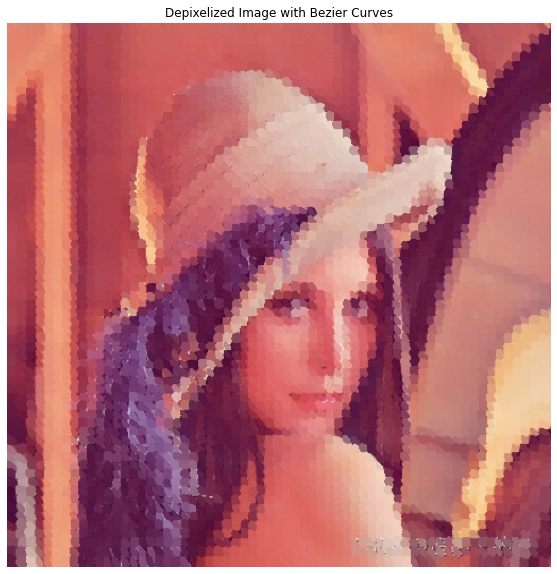

True

In [5]:
import numpy as np
import cv2
import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# 定義參數
img_path = './src/Lena.png'
save_path = './output5/Lena.png'
k = 4000
SLIC_ITERATIONS = 10
m = 1000

def generate_pixels():
    indnp = np.mgrid[0:SLIC_height, 0:SLIC_width].swapaxes(0, 2).swapaxes(0, 1)
    
    for i in tqdm.tqdm(range(SLIC_ITERATIONS)):
        SLIC_distances = 1 * np.ones(img.shape[:2])
        
        for j in range(SLIC_centers.shape[0]):
            x_low, x_high = int(SLIC_centers[j][3] - step), int(SLIC_centers[j][3] + step)
            y_low, y_high = int(SLIC_centers[j][4] - step), int(SLIC_centers[j][4] + step)
            
            if x_low <= 0:
                x_low = 0
            if x_high > SLIC_width:
                x_high = SLIC_width
            if y_low <= 0:
                y_low = 0
            if y_high > SLIC_height:
                y_high = SLIC_height
            
            cropimg = SLIC_labimg[y_low: y_high, x_low: x_high]
            color_diff = cropimg - SLIC_labimg[int(SLIC_centers[j][4]), int(SLIC_centers[j][3])]
            color_distances = np.sqrt(np.sum(np.square(color_diff), axis=2))
            
            yy, xx = np.ogrid[y_low: y_high, x_low: x_high]
            pixdist = ((yy - SLIC_centers[j][4])**2 + (xx - SLIC_centers[j][3])**2)**0.5
            dist = ((color_distances / SLIC_m) ** 2 + (pixdist / step) ** 2) ** 0.5
            distance_crop = SLIC_distances[y_low: y_high, x_low: x_high]
            idx = dist < distance_crop
            distance_crop[idx] = dist[idx]
            SLIC_distances[y_low: y_high, x_low: x_high] = distance_crop
            SLIC_clusters[y_low: y_high, x_low: x_high][idx] = j
            
        for k in range(len(SLIC_centers)):
            idx = (SLIC_clusters == k)
            colornp = SLIC_labimg[idx]
            distnp = indnp[idx]
            SLIC_centers[k][0:3] = np.sum(colornp, axis=0)
            sumy, sumx = np.sum(distnp, axis=0)
            SLIC_centers[k][3:] = sumx, sumy
            SLIC_centers[k] /= np.sum(idx)

def display_contours(color):
    is_taken = np.zeros(img.shape[:2], np.bool_)
    contours = []
    
    for i in range(SLIC_width):
        for j in range(SLIC_height):
            nr_p = 0
            for dx, dy in [(-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)]:
                x = i + dx
                y = j + dy
                if (x >= 0 and x < SLIC_width and y >= 0 and y < SLIC_height):
                    if not is_taken[y,x] and SLIC_clusters[j,i] != SLIC_clusters[y,x]:
                        nr_p += 1
            if nr_p >= 2:
                is_taken[j,i] = True
                contours.append([j,i])
            
def create_connectivity():
    label = 0
    adj_label = 0
    lims = int(SLIC_width * SLIC_height / SLIC_centers.shape[0])
    
    new_clusters = -1 * np.ones(img.shape[:2]).astype(np.int64)
    elements = []
    for i in range(SLIC_width):
        for j in range(SLIC_height):
            if new_clusters[j,i] == -1:
                elements = []
                elements.append((j,i))
                for dx, dy in [(-1, 0), (0, -1), (1, 0), (0, 1)]:
                    x = elements[0][1] + dx
                    y = elements[0][0] + dy
                    if (x >= 0 and x < SLIC_width and y >= 0 and y < SLIC_height 
                            and new_clusters[y,x] >= 0):
                        adj_label = new_clusters[y,x]
        
        count = 1
        counter = 0
        while counter < count:
            for dx, dy in [(-1, 0), (0, -1), (1, 0), (0, 1)]:
                x = elements[counter][1] + dx
                y = elements[counter][0] + dy
                if (x >= 0 and x < SLIC_width and y >= 0 and y < SLIC_height):
                    if new_clusters[y,x] == -1 and SLIC_clusters[j,i] == SLIC_clusters[y,x]:
                        elements.append((y,x))
                        new_clusters[y,x] = label
                        count += 1
            counter += 1
            
        if (count <= lims >> 2):
            for counter in range(count):
                new_clusters[elements[counter]] = adj_label
                
            label -= 1
            
        label += 1
            
    SLIC_new_clusters = new_clusters
            
def find_local_minimum(center):
    min_grad = 1
    loc_min = center
    for i in range(center[0] - 1, center[0] + 2):
        for j in range(center[1] - 1, center[1] + 2):
            c1 = SLIC_labimg[j+1, i]
            c2 = SLIC_labimg[j, i+1]
            c3 = SLIC_labimg[j, i]
            if ((c1[0] - c3[0])**2)**0.5 + ((c2[0] - c3[0])**2)**0.5 < min_grad:
                min_grad = abs(c1[0] - c3[0]) + abs(c2[0] - c3[0])
                loc_min = [i, j]
    return loc_min
            
def calculate_centers():
    centers = []
    for i in range(step, SLIC_width - int(step/2), step):
        for j in range(step, SLIC_height - int(step/2), step):
            nc = find_local_minimum(center=(i, j))
            color = SLIC_labimg[nc[1], nc[0]]
            center = [color[0], color[1], color[2], nc[0], nc[1]]
            centers.append(center)
    return centers
            
            
img = cv2.imread(img_path)
mask = 255 * np.ones(img.shape).astype('uint8')
step = int((img.shape[0]*img.shape[1] / k) ** 0.5)
SLIC_m = m
SLIC_height, SLIC_width = img.shape[:2]
SLIC_labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float64)

SLIC_distances = 1 * np.ones(img.shape[:2])
SLIC_clusters = -1 * SLIC_distances
SLIC_center_counts = np.zeros(len(calculate_centers()))
SLIC_centers = np.array(calculate_centers())

# main
generate_pixels()
create_connectivity()
calculate_centers()
display_contours([0.0, 0.0, 0.0])
img2 = np.hstack((img, mask))
#cv2.imwrite(save_path, img2)

# Find the edge of all superpixels
contours = []
for segment_label in np.unique(SLIC_clusters): 
    mask = SLIC_clusters == segment_label  # Create a mask for the current superpixel
    mask = mask.astype(np.uint8)
    contour = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours of the superpixel
    contour = contour[0] if len(contour) == 2 else contour[1]
    if len(contour) > 0 and len(contour[0]) >= 4:  # Ensure there are enough points for the spline
        contours.append(contour[0].squeeze())   # Add the contour to the list

# Create an image to draw the depixelized result
depixelized_image = img.copy()

# Draw Bezier curves on each superpixel
for contour in contours:
    if len(contour) >= 4:
        try:
            tck, u = splprep(contour.T, s=3, per=True)
            u_new = np.linspace(u.min(), u.max(), 1000)
            x_new, y_new = splev(u_new, tck, der=0)
        
            bezier_contour = np.vstack((x_new, y_new)).T
            bezier_contour = bezier_contour.astype(np.int32)
        
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            cv2.fillPoly(mask, [bezier_contour], 255)
        
            average_color = cv2.mean(img, mask=mask)[:3]
            cv2.fillPoly(depixelized_image, [bezier_contour], average_color)
        except ValueError as e:
            print(f"Error processing contour: {e}")

# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2.cvtColor(depixelized_image, cv2.COLOR_BGR2RGB))
ax.set_title('Depixelized Image with Bezier Curves')
plt.axis('off')
plt.show()

# Save images
output_path = save_path
cv2.imwrite(output_path, depixelized_image)

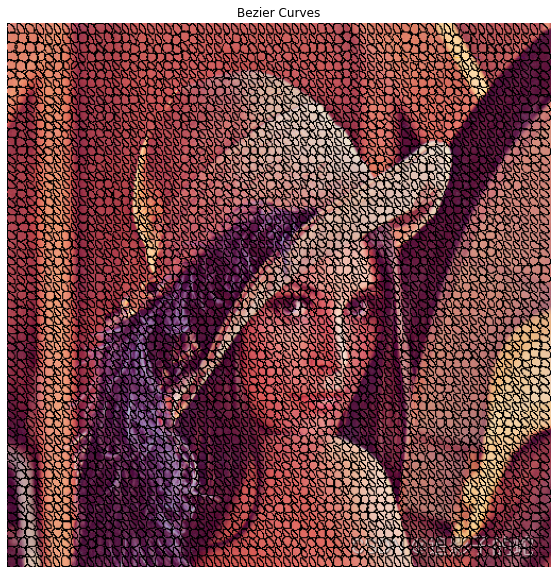

In [6]:
# Create an empty image to draw the Bezier curves without filling colors
bezier_image = img.copy()

# Draw Bezier curves on the empty image
for contour in contours:
    if len(contour) >= 4:
        try:
            tck, u = splprep(contour.T, s=3, per=True)
            u_new = np.linspace(u.min(), u.max(), 100)
            x_new, y_new = splev(u_new, tck, der=0)
        
            bezier_contour = np.vstack((x_new, y_new)).T
            bezier_contour = bezier_contour.astype(np.int32)
        
            cv2.polylines(bezier_image, [bezier_contour], isClosed=True, color=(0, 0, 0), thickness=1)
        except ValueError as e:
            print(f"Error processing contour: {e}")
            
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2.cvtColor(bezier_image, cv2.COLOR_BGR2RGB))
ax.set_title('Bezier Curves')
plt.axis('off')
plt.show()


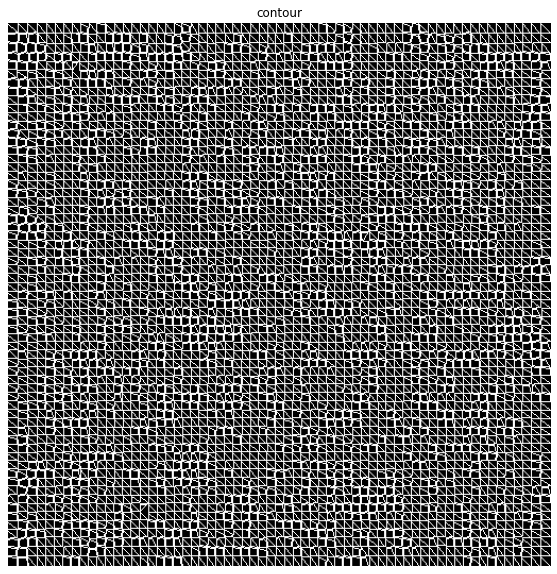

In [7]:
# Create an empty image to draw the superpixel contours without filling colors
contour_image = np.zeros_like(img)

# Draw superpixel contours on the empty image
for contour in contours:
    cv2.polylines(contour_image, [contour], isClosed=True, color=(255, 255, 255), thickness=1)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
ax.set_title('contour')
plt.axis('off')
plt.show()
    